# Notebook 01: Data Ingest & Deterministic Battery Dispatch
This notebook loads PJM real-time hourly LMPs (Western Hub), cleans them into a tidy time series, and solves a deterministic 24‑hour battery dispatch linear program (LP) for a representative day.

**Battery base case:** 50 MW / 200 MWh (4‑hour), round‑trip efficiency 90%, initial & terminal SOC = 50%.


## 0. Setup

In [14]:
# !pip -q install pyomo highspy pandas numpy matplotlib

import sys
from pathlib import Path

# Add repo src/ to path
repo_root = Path('..').resolve()
sys.path.append(str(repo_root / 'src'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_utils import load_pjm_prices_csv
from models import solve_deterministic_dispatch

## 1. Load PJM price data
Download **PJM Data Miner 2 → Real‑Time Hourly LMPs** for `WESTERN HUB` and save the CSV to `data/raw/`.

Expected columns include `datetime_beginning_ept` and `total_lmp_rt`.


In [15]:
data_path = repo_root / "data" / "raw" / "pjm_rt_hourly_western_hub_2025Q1.csv"
df = load_pjm_prices_csv(str(data_path))
df.head()

C:\Users\melsh\Documents\my_workspace\energy-storage-dispatch-risk-aware-optimization\src\data_utils.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out["timestamp"] = pd.to_datetime(out["timestamp"])


,timestamp,price
0,2025-01-01 00:00:00,19.929348
1,2025-01-01 01:00:00,20.164973
2,2025-01-01 02:00:00,19.278767
3,2025-01-01 03:00:00,19.420208
4,2025-01-01 04:00:00,19.565295


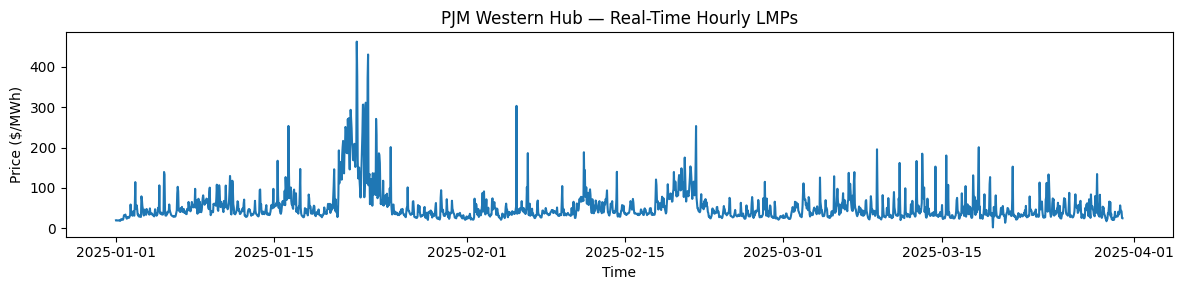

In [16]:
# Price sanity plot
plt.figure(figsize=(12,3))
plt.plot(df["timestamp"], df["price"])
plt.title("PJM Western Hub — Real-Time Hourly LMPs")
plt.xlabel("Time")
plt.ylabel("Price ($/MWh)")
plt.tight_layout()
plt.show()

## 2. Solve deterministic dispatch for one day
We solve a deterministic LP assuming the 24‑hour price path is known (perfect foresight) as a baseline.


In [17]:
day = "2025-01-15"
df_day = df[df["timestamp"].dt.date == pd.to_datetime(day).date()].reset_index(drop=True)

assert len(df_day) == 24, f"Expected 24 hourly points for {day}, got {len(df_day)}"
prices = df_day["price"].to_numpy()

det_plan = solve_deterministic_dispatch(prices)
det_plan.head()

,hour,charge,discharge,soc
0,0,50.0,0.00000,147.434165
1,1,0.0,0.00000,147.434165
2,2,0.0,0.00000,147.434165
3,3,50.0,0.00000,194.868330
4,4,0.0,34.86833,158.113883


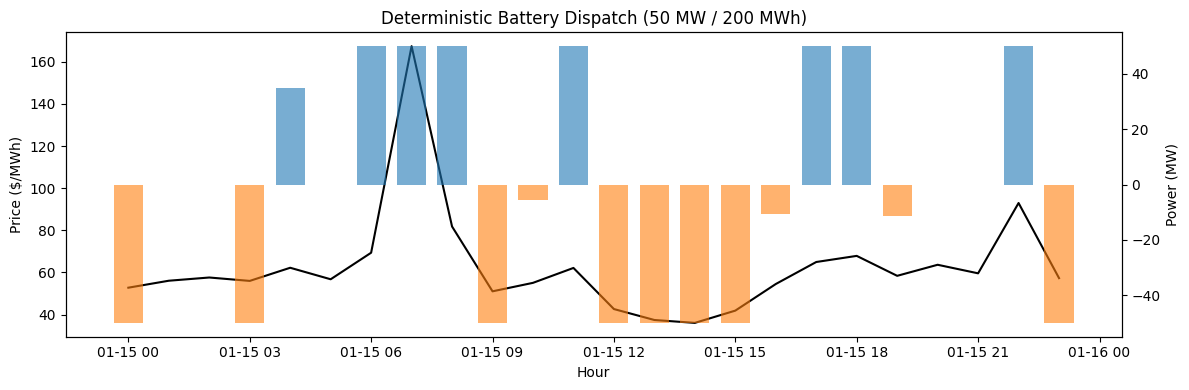

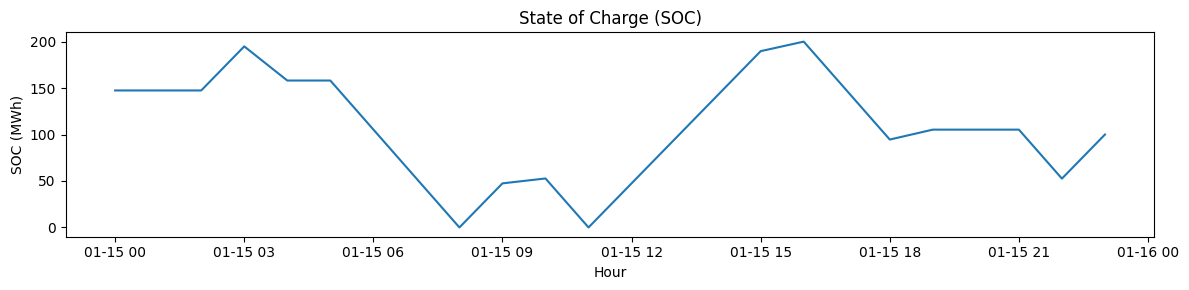

In [18]:
# Plot: price + dispatch
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df_day["timestamp"], df_day["price"], color="black")
ax1.set_ylabel("Price ($/MWh)")
ax1.set_xlabel("Hour")

ax2 = ax1.twinx()
ax2.bar(df_day["timestamp"], det_plan["discharge"], width=0.03, alpha=0.6, label="Discharge")
ax2.bar(df_day["timestamp"], -det_plan["charge"], width=0.03, alpha=0.6, label="Charge")
ax2.set_ylabel("Power (MW)")

plt.title("Deterministic Battery Dispatch (50 MW / 200 MWh)")
plt.tight_layout()
plt.show()

# Plot: SOC
plt.figure(figsize=(12,3))
plt.plot(df_day["timestamp"], det_plan["soc"])
plt.title("State of Charge (SOC)")
plt.xlabel("Hour")
plt.ylabel("SOC (MWh)")
plt.tight_layout()
plt.show()

## 3. Findings (deterministic baseline)
> Deterministic battery dispatch produces economically intuitive behavior under real-time PJM prices. The battery charges during low-price hours and discharges into price spikes, with both power and energy constraints binding at multiple points. SOC stays within physical limits and returns to its initial level at the end of the horizon, preventing end-of-horizon artifacts. This validates the LP formulation and establishes a baseline for risk-aware extensions.
